# Image Offsets: Find stars

This notebook combines the procedures developed in `Background.ipynb` and `White_light_images.ipynb` notebooks to build images suitable for star finding. Then it applies `photutils` tools to find star images and build  tables with centroid locations. 

There is also a statistical analysis to see how star shapes depend on the RGB normalization coefficients. 

Later we proceed to find stars in a few contiguous images in the sequence, to see how:
 - to correlate the detections that are stored in separate tables;
 - to keep track of the offsets from each n-th image to the reference n=0 image
 
There is code to save the offsets table to a FITS file.
 
No flat field, bias, or dark calibrations are required here. Note that, for the Sony Alpha camera used to get these data sets, they are not likely to be ever needed.

In [1]:
# %pylab notebook
# %matplotlib notebook

import os

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from photutils import centroids
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy

from datapath import DATA

/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_4211/876629329.py:17: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture
/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_4211/876629329.py:17: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground, DAOStarFinder, CircularAperture
/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_4211/876629329.py:17: DeprecationWarning: `photutils.ModeEstimatorBackg

In [2]:
# 1st test image - this will be the reference image against with subsequent images
# will have their offsets computed. We need it here at the top of the script so
# its size can be known from the start.
# fname = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW'
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [3]:
# parameters to control background subtraction
bkg_cell_footprint = (100, 100)
bkg_filter = (9, 9)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=1)
bkg_estimator = ModeEstimatorBackground()

# parameters for star finding
dao_fwhm = 4.5
dao_threshold = 2000.
sharplo = 0.1
sharphi = 1.0
roundlo = -0.9 
roundhi = 0.9

In [4]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

## Functions

In [5]:
def subtract_background(imarray, red_norm=1.0, blue_norm=1.0):

    # red_norm and blue_norm are normalization parameters applied to the R and B bands (assume
    # G=1) in order to make the star images as well-behaved as possible, in terms of being 
    # well represented, on average, by the daofind Gaussian. Ideally a different normalization 
    # should be applied to each star, depending on its color index, but this will be left as
    # a possible (but not very likely) future improvement. For now, we assume that an average,
    # frame-wide single normalization should suffice (statistically).
    
    # separate color bands
    red_array = imarray * red_mask
    green_array = imarray * green_mask
    blue_array = imarray * blue_mask
    
    # interpolate over the masked pixels in each band, so the background estimator 
    # is presented with a smooth array entirely filled with valid data
    red_array[red_array == 0.0] = np.nan
    green_array[green_array == 0.0] = np.nan
    blue_array[blue_array == 0.0] = np.nan

    red_array = interpolate_replace_nans(red_array, bkg_kernel)
    green_array = interpolate_replace_nans(green_array, bkg_kernel)
    blue_array = interpolate_replace_nans(blue_array, bkg_kernel)

    red_array[np.isnan(red_array)] = 0.
    green_array[np.isnan(green_array)] = 0.
    blue_array[np.isnan(blue_array)] = 0.
    
    # fit background model to each smoothed-out color band
    red_bkg = Background2D(red_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    green_bkg = Background2D(green_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    blue_bkg = Background2D(blue_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

    # subtract background from each masked color array
    subtracted = imarray - red_bkg.background * red_mask - \
                           green_bkg.background * green_mask - \
                           blue_bkg.background * blue_mask

    # after background subtraction, apply color band normalization. This has to be done separately
    # from step above for the background on each band to remain zero on average.
    subtracted = (subtracted * red_mask * red_norm) + \
                 (subtracted * green_mask) + \
                 (subtracted * blue_mask * blue_norm)

    return subtracted, red_bkg

In [6]:
class CentroidFinder():
    def __init__(self, x_estimate, y_estimate, size, sky, threshold):
        self.x_estimate = x_estimate
        self.y_estimate = y_estimate
        self.sky = sky
        self.threshold = threshold
        self.size = int(size * 2) + 1
        
        self.result = Table()
        
    def find(self, image):
        x, y = centroids.centroid_sources(image, self.x_estimate, self.y_estimate, 
                                          box_size=self.size, centroid_func=centroids.centroid_com)                

        self.result.add_column(x, name='xcentroid')
        self.result.add_column(y, name='ycentroid')

        return self.result                

## Process first image

In [7]:
subtracted, red_bkg = subtract_background(imarray, red_norm=1.38, blue_norm=1.43)

22655.939884293133
Relative standard deviation of a smooth patch:  11.296556056271015


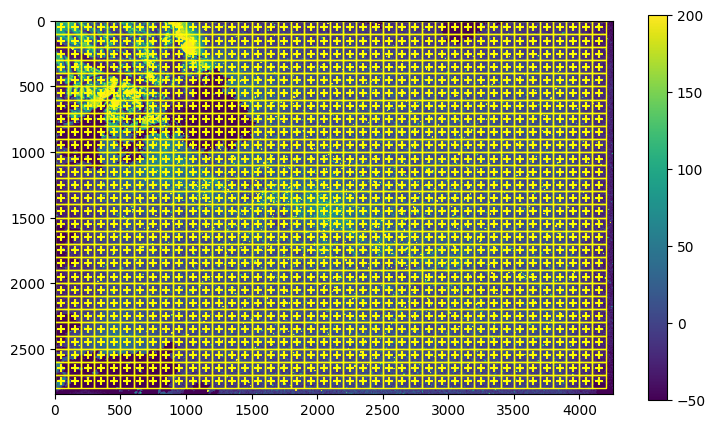

In [8]:
plt.figure(figsize=[9, 5])
print(np.max(subtracted))
plt.imshow(subtracted, vmin=-50, vmax=200)
red_bkg.plot_meshes(outlines=True, color='yellow')
plt.colorbar()

section = subtracted[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

In [9]:
# find star images. For the first image, we use daofind.
global_median = np.median(subtracted)
daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                        sharplo=sharplo, sharphi=sharphi,
                        roundlo=roundlo, roundhi=roundhi)
sources = daofind(subtracted)  
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2076.9808927678846,25.686603048746466,0.6740658535416257,0.3864688975157531,0.48554712751802964,25,-1.3725119843608593,10880.133701724957,40.587393792463715,-4.0209779129759795
2,3252.2040237738534,29.541027377718464,0.2907932254931666,-0.5037660666035332,0.06058393832113418,25,-1.3725119843608593,1568.0605000143762,35.86356023252436,-3.8866335011712905
3,49.893108115378276,30.986974990630447,0.49397080621458617,-0.40380399846603526,-0.5767725490674868,25,-1.3725119843608593,2854.8955008940115,35.808599544797126,-3.884968340797002
4,2466.9663359039387,34.89908339301699,0.6555085525120963,0.11644939833690562,0.32997559522615316,25,-1.3725119843608593,7991.057481570751,39.176970018251964,-3.9825771105889367
5,1672.9980517676088,35.91418177750541,0.7398047308479088,0.538548159087764,0.43818152823830614,25,-1.3725119843608593,2627.74835488998,35.68451753731533,-3.8811995734344755
6,1847.5293282316252,50.8647098008768,0.5915236471442489,0.7274578367093266,0.003419978818332779,25,-1.3725119843608593,4787.2474925610195,37.12576982978884,-3.9241886695749875
7,1180.8040899071912,55.0569360131736,0.7211682367199519,0.26995638149143325,-0.2597062453781767,25,-1.3725119843608593,6806.519277133643,37.80324235458167,-3.9438226263334117
8,2808.2327380404677,71.26997398646105,0.9668130174580444,-0.008407591136708541,0.039157822927287436,25,-1.3725119843608593,3982.8711127623187,36.051287149965034,-3.8923019376974244
9,1621.0945126641334,76.93333911116633,0.6815562359851114,0.5807967261233316,0.19082121484663367,25,-1.3725119843608593,2728.896953237685,35.76745931321631,-3.8837202295002644


In [10]:
# statistics
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

Mean roundness:  -0.039954467693087393 stdev:  0.25511966757795523
Mean sharpness:  0.7022460351136547 stdev:  0.22242837996436057


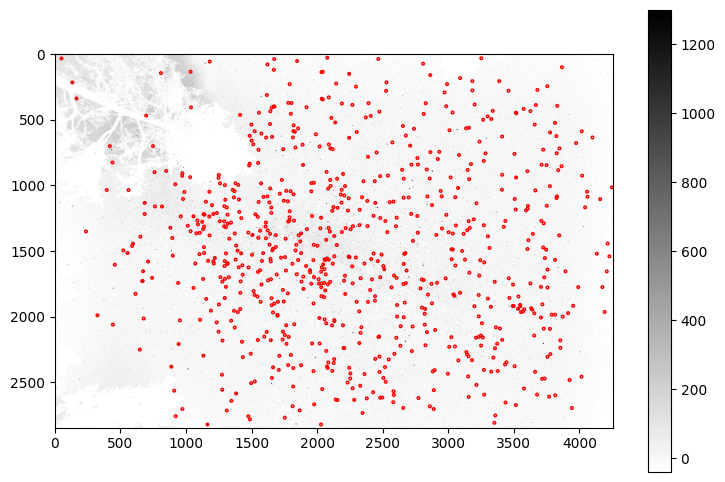

In [11]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')

## Statistical analysis

These notebook cells (normally not executed) are used to find optimal R and B normalization factors that would minimize roudness (or maximize sharpness).

In [12]:
# optimization functions
def stats(table):
    mean_roundness = np.average(table['roundness1'])
    mean_sharpness = np.average(table['sharpness'])
    stdev_roundness = np.std(table['roundness1'])
    
    print(mean_roundness, mean_sharpness, stdev_roundness)

#     return abs(stdev_roundness)    # min roundness stdev
    return abs(mean_roundness)    # zero roundness
#     return 1./ mean_sharpness   # maximum shapness

def objective_function(coeffs):
    
    red_norm = coeffs[0]
    blue_norm = coeffs[1]
    
    subtracted, _ = subtract_background(imarray, red_norm=red_norm, blue_norm=blue_norm)
    
    global_median = np.median(subtracted)
    daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                            sharplo=sharplo, sharphi=sharphi,
                            roundlo=roundlo, roundhi=roundhi)
    sources = daofind(subtracted)
    
    return stats(sources)  

In [13]:
# raw = rawpy.imread(fname)
# imarray = raw.raw_image_visible.astype(float)

# res = minimize(objective_function, (1.3, 1.3), method='Nelder-Mead', tol=1.5e-2)
# print(res.x, res.fun)

In [14]:
# subtract background from each masked color array, but now with the optimized normalization
# factors that make the star images the roundest. 
subtracted, red_bkg = subtract_background(imarray, red_norm=1.60, blue_norm=1.39)

In [15]:
# find stars 
global_median = np.median(subtracted)
daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                        sharplo=sharplo, sharphi=sharphi,
                        roundlo=roundlo, roundhi=roundhi)

sources = daofind(subtracted)  

print("# detections: ", len(sources))
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

# detections:  805
Mean roundness:  -0.03545586904832442 stdev:  0.25398592222399236
Mean sharpness:  0.7150585614100463 stdev:  0.2084444767230832


## Correlate two contiguous images

In [16]:
# this is the next image after the test image used at the beginning of the notebook
fname2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03780.ARW')
raw2 = rawpy.imread(fname2)
imarray2 = raw2.raw_image_visible.astype(float)

In [17]:
subtracted2, _ = subtract_background(imarray2, red_norm=1.60, blue_norm=1.39)

In [18]:
global_median = np.median(subtracted2)

# provide positions
x_estimate = sources['xcentroid']
y_estimate = sources['ycentroid']
# positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]

# we have been using DAOStarFinder for all steps, but it fails in reproducing 
# the same detections on image pairs. Lets try instead a hands-on approach with 
# a simpler substitute. 
# daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                         sky=global_median,
#                         threshold=dao_threshold,
#                         sharplo=sharplo, sharphi=sharphi,
#                         roundlo=roundlo, roundhi=roundhi) 
# sources2 = daofind(subtracted2)

starfinder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2, global_median, dao_threshold)
sources2 = starfinder.find(subtracted2)

sources2


xcentroid,ycentroid
float64,float64
2076.1207361382812,26.09287222118651
3249.0643337851557,30.365588730032826
49.70442611166695,31.777167436546893
2439.3127360139783,40.36076419490814
1671.4018628175268,35.85688201509095
4107.998893851419,43.16513451876284
1846.6031895896424,51.27875845858618
1180.929061730347,55.67335302003819
2806.755425805904,71.00244273915519


In [19]:
global_median

-1.422678251403886

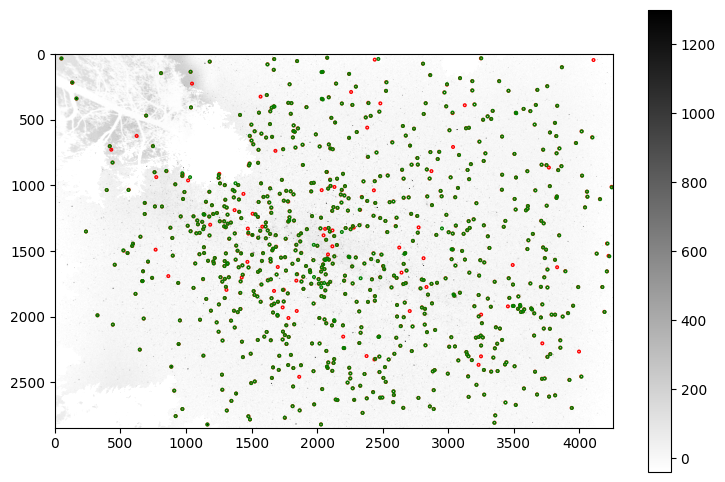

In [20]:
# plot positions from both first and second images
positions2 = [(x,y) for x,y in zip(sources2['xcentroid'], sources2['ycentroid'])]
apertures2 = CircularAperture(positions2, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2 = apertures2.plot(color='red')
ap_ = apertures.plot(color='green') # first image

### Build table with offsets in star positions

First thing to do is to find each pair of stars, one in each table.

For that, we use the centroid positions: for every star in the first table, look for the one star in the second table whose position differs by less than 1.5 pixel (in both X and Y coords).

We also need to store two pointers in the second table. To allow navigation in the list of tables associated to a set of images:

 - the row number of the same star in the reference (first) table.
 - the row number of the same star in the *previous* image in the sequence.
 
The reference image won't have neither of these columns. In the 2nd table in the sequence, these columns will be redundant.

In [21]:
sources2.add_column(np.nan, name='xoffset')
sources2.add_column(np.nan, name='yoffset')
sources2.add_column(0, name='ref_row')
sources2.add_column(0, name='prev_row') # redundant for the 2nd image in sequence

for row_index in range(len(sources)):
    x = sources[row_index]['xcentroid']
    y = sources[row_index]['ycentroid']
    
    for row2_index in range(len(sources2)):
        x2 = sources2[row2_index]['xcentroid']
        y2 = sources2[row2_index]['ycentroid']
        x_off = x2 - x
        y_off = y2 - y
        if abs(x_off) <= 1.5 and abs(y_off) <= 1.5:
            sources2[row2_index]['xoffset'] = x_off
            sources2[row2_index]['yoffset'] = y_off
            sources2[row2_index]['ref_row'] = row_index
            sources2[row2_index]['prev_row'] = row_index
            
            break # if there is another star that matches the criterion, just ignore it

In [22]:
sources2  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2076.1207361382812,26.09287222118651,-0.8592608448188912,0.3885659855261352,0,0
3249.0643337851557,30.365588730032826,nan,nan,0,0
49.70442611166695,31.777167436546893,-0.19242971806665565,0.8000265512296281,2,2
2439.3127360139783,40.36076419490814,nan,nan,0,0
1671.4018628175268,35.85688201509095,nan,nan,0,0
4107.998893851419,43.16513451876284,nan,nan,0,0
1846.6031895896424,51.27875845858618,-0.9418465026906233,0.4214866891209397,6,6
1180.929061730347,55.67335302003819,0.1473993342583526,0.6240765959950707,7,7
2806.755425805904,71.00244273915519,-1.4644289538996418,-0.28085165820860425,8,8


In [23]:
# stats
print(np.nanmean(sources2['xoffset']), np.nanstd(sources2['xoffset']))
print(np.nanmean(sources2['yoffset']), np.nanstd(sources2['yoffset']))
print(np.count_nonzero(~np.isnan(sources2['xoffset'])))

-0.3695893883391044 0.6005833284175959
-0.08936484110897404 0.5909025983349564
652


In [24]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources2), dtype=bool)
xoff = np.array(sources2['xoffset'])
has_nan |= np.isnan(xoff)
sources2_no_nan = sources2[~has_nan]

In [25]:
sources2_no_nan

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2076.1207361382812,26.09287222118651,-0.8592608448188912,0.3885659855261352,0,0
49.70442611166695,31.777167436546893,-0.19242971806665565,0.8000265512296281,2,2
1846.6031895896424,51.27875845858618,-0.9418465026906233,0.4214866891209397,6,6
1180.929061730347,55.67335302003819,0.1473993342583526,0.6240765959950707,7,7
2806.755425805904,71.00244273915519,-1.4644289538996418,-0.28085165820860425,8,8
1621.6281519063252,75.61610569514451,0.5465338998812967,-1.3029639494403682,9,9
3866.4957612689714,97.79501645888921,-0.608701392900457,-0.36831384421995494,10,10
1034.6784900304958,133.00368571639726,-0.11377458528386342,0.43891317150666964,12,12
809.7085348590715,143.32487254707237,0.7462885125779621,0.46005353950428685,15,15


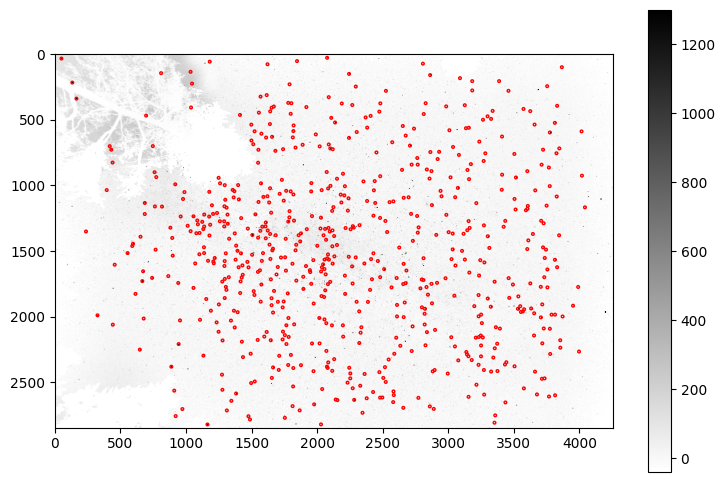

In [26]:
positions2_n = [(x,y) for x,y in zip(sources2_no_nan['xcentroid'], sources2_no_nan['ycentroid'])]
apertures2_n = CircularAperture(positions2_n, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2_n = apertures2_n.plot(color='red')

## Add third image in sequence

The table associated to this image should contain offsets in relation to the first image. But to find star pairs, the code must use the second image. That is, the image immediately before it in the image time sequence.

We may want to add the image name (or path) to the table header.

In [27]:
# this is the next, third image 
fname3 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03781.ARW')
raw3 = rawpy.imread(fname3)
imarray3 = raw3.raw_image_visible.astype(float)

In [28]:
subtracted3, _ = subtract_background(imarray3, red_norm=1.60, blue_norm=1.39)

global_median = np.median(subtracted3)

# provide positions
x_estimate = sources2_no_nan['xcentroid']
y_estimate = sources2_no_nan['ycentroid'] 
# positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]
# daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                         sky=global_median,
#                         threshold=dao_threshold,
#                         sharplo=sharplo, sharphi=sharphi,
#                         roundlo=roundlo, roundhi=roundhi) 

starfinder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2, global_median, dao_threshold)
sources3 = starfinder.find(subtracted3)

In [29]:
sources3  

xcentroid,ycentroid
float64,float64
2075.3596226648374,26.296527661387724
48.65945750937008,32.22811090408364
1845.6597968526296,51.313042208964305
1179.5474456113113,55.81439258289252
2805.1732933919793,72.18690829654001
1619.886540433735,77.06191864925785
3865.3174887157115,96.96285458113431
1034.4042327697352,133.36102885564375
813.0640062201056,143.44615651541636


Here we do the more general table operation to correlate the positions just gotten from the 3rd image, with the positions from the second image. But storing offsets in relation to the first (reference) image.

In [30]:
sources3.add_column(np.nan, name='xoffset')
sources3.add_column(np.nan, name='yoffset')
sources3.add_column(0, name='ref_row')
sources3.add_column(0, name='prev_row')

# loop over rows in 2nd table
for row_index2 in range(len(sources2_no_nan)):
    # get position in 2nd table, and index in 1st table
    x2 = sources2_no_nan[row_index2]['xcentroid']
    y2 = sources2_no_nan[row_index2]['ycentroid']
    ref_row = sources2_no_nan[row_index2]['ref_row']
    
    if ref_row == 0:
        continue

    # loop over rows in 3rd (newest) table
    for row_index3 in range(len(sources3)):
        x3 = sources3[row_index3]['xcentroid']
        y3 = sources3[row_index3]['ycentroid']
        
        # offsets in relation to 2nd table - these are the ones to check for proximity
        x32_off = x3 - x2
        y32_off = y3 - y2
        
        # offsets in relation to reference table
        x_ref = sources[ref_row]['xcentroid']
        y_ref = sources[ref_row]['ycentroid']
        x_off = x3 - x_ref
        y_off = y3 - y_ref

        if abs(x32_off) <= 1.5 and abs(y32_off) <= 1.5:
            sources3[row_index3]['xoffset'] = x_off
            sources3[row_index3]['yoffset'] = y_off
            
            # store pointers to rows in reference and previous tables
            sources3[row_index3]['ref_row'] = ref_row
            sources3[row_index3]['prev_row'] = row_index2
            
            break # if there is another star that matches the criterion, just ignore it

In [31]:
sources3  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2075.3596226648374,26.296527661387724,nan,nan,0,0
48.65945750937008,32.22811090408364,-1.2373983203635248,1.2509700187663775,2,1
1845.6597968526296,51.313042208964305,-1.8852392397034237,0.45577043949906226,6,2
1179.5474456113113,55.81439258289252,-1.2342167847773453,0.765116158849402,7,3
2805.1732933919793,72.18690829654001,nan,nan,0,0
1619.886540433735,77.06191864925785,nan,nan,0,0
3865.3174887157115,96.96285458113431,-1.7869739461602876,-1.200475721974854,10,6
1034.4042327697352,133.36102885564375,-0.3880318460444414,0.796256310753165,12,7
813.0640062201056,143.44615651541636,nan,nan,0,0


In [32]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources3), dtype=bool)
xoff = np.array(sources3['xoffset'])
has_nan |= np.isnan(xoff)
sources3_no_nan = sources3[~has_nan]

In [33]:
sources3_no_nan  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
48.65945750937008,32.22811090408364,-1.2373983203635248,1.2509700187663775,2,1
1845.6597968526296,51.313042208964305,-1.8852392397034237,0.45577043949906226,6,2
1179.5474456113113,55.81439258289252,-1.2342167847773453,0.765116158849402,7,3
3865.3174887157115,96.96285458113431,-1.7869739461602876,-1.200475721974854,10,6
1034.4042327697352,133.36102885564375,-0.3880318460444414,0.796256310753165,12,7
2242.607587799385,149.08926301619587,-1.5747300910215927,0.08546345491186003,16,9
2861.160691861177,158.0972212484043,-1.8598048736334931,0.0021517450297210416,17,10
3088.6718362730066,181.48027708895876,-1.5812976101724416,0.3008419344329525,18,11
3182.1198381331033,204.4483662615012,-1.900300807113581,0.28545486309548096,19,12


In [34]:
# stats
print(np.nanmean(sources3_no_nan['xoffset']), np.nanstd(sources3_no_nan['xoffset']))
print(np.nanmean(sources3_no_nan['yoffset']), np.nanstd(sources3_no_nan['yoffset']))
print(np.count_nonzero(~np.isnan(sources3_no_nan['xoffset'])))

-0.7319532778491707 0.8328535700212586
-0.08417536771789455 0.8308090407673803
606


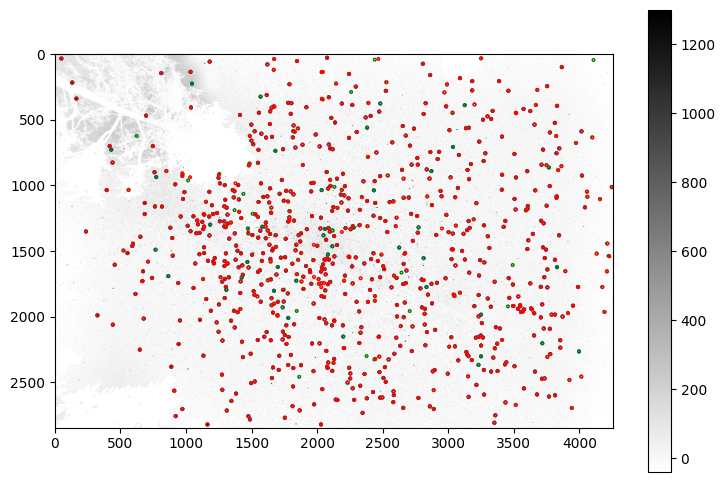

In [35]:
# plot positions from 3 images
positions3 = [(x,y) for x,y in zip(sources3['xcentroid'], sources3['ycentroid'])]
apertures3 = CircularAperture(positions3, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted3, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap3 = apertures3.plot(color='blue')
ap2 = apertures2.plot(color='green') 
ap1 = apertures.plot(color='red') 

## Save to file

In [36]:
sources3_no_nan.write('table.fits', format='fits', overwrite=True)

In [37]:
test = Table.read('table.fits')
test

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
48.65945750937008,32.22811090408364,-1.2373983203635248,1.2509700187663775,2,1
1845.6597968526296,51.313042208964305,-1.8852392397034237,0.45577043949906226,6,2
1179.5474456113113,55.81439258289252,-1.2342167847773453,0.765116158849402,7,3
3865.3174887157115,96.96285458113431,-1.7869739461602876,-1.200475721974854,10,6
1034.4042327697352,133.36102885564375,-0.3880318460444414,0.796256310753165,12,7
2242.607587799385,149.08926301619587,-1.5747300910215927,0.08546345491186003,16,9
2861.160691861177,158.0972212484043,-1.8598048736334931,0.0021517450297210416,17,10
3088.6718362730066,181.48027708895876,-1.5812976101724416,0.3008419344329525,18,11
3182.1198381331033,204.4483662615012,-1.900300807113581,0.28545486309548096,19,12
